# note: 
please create a fresh Anaconda env:<br>
`conda create -n allensdk pip numpy=1.18.1 pandas=0.25.1 jupyterlab`<br>
`conda activate allensdk`<br>
`pip install allensdk`

and relaunch this Jupyter Lab server:<br>
`jupyter lab`<br>
before running this notebook

In [12]:
!pip install allensdk --no-dependencies
!pip install xarray pynwb requests_toolbelt

  Using cached requests_toolbelt-0.9.1-py2.py3-none-any.whl (54 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allensdk 2.13.6 requires argschema<4.0.0,>=3.0.1, which is not installed.
allensdk 2.13.6 requires boto3==1.17.21, which is not installed.
allensdk 2.13.6 requires ndx-events<=0.2.0, which is not installed.
allensdk 2.13.6 requires scikit-build<1.0.0, which is not installed.
allensdk 2.13.6 requires aiohttp==3.7.4, but you have aiohttp 3.8.1 which is incompatible.
allensdk 2.13.6 requires matplotlib<3.4.3,>=1.4.3, but you have matplotlib 3.5.1 which is incompatible.
allensdk 2.13.6 requires scikit-image<0.17.0,>=0.14.0, but you have scikit-image 0.19.2 which is incompatible.
allensdk 2.13.6 requires statsmodels<=0.13.0, but you have statsmodels 0.13.2 which is incompatible.
allensdk 2.13.6 requires tables<3.7.0,>=3.6.0, but you have tables 3.7.0 w

# Time Series - Patch Clamp Analysis with Python in a Jupyter notebook
#### We're going to use data from the Allen Institute for Brain Science Cell Types project. This is patch clamp data data collected in several cortical areas in the mouse brain. We'll get the data using the [Allen Software Development Kit](https://allensdk.readthedocs.io/en/latest/), which Python to programmatically access [this data](https://allensdk.readthedocs.io/en/latest/cell_types.html). From the Allen documentation:
"Whole cell patch clamp recordings provide basic information about cell firing properties. Recordings are
performed using a range of stimulus protocols, including short pulses, long steps, slow ramps, and naturalistic
noise to characterize the intrinsic properties of these neurons...Electrophysiological data collected from individual whole-cell recordings consisted of high temporal resolution time series of membrane potential (in current-clamp mode) and trans-membrane current measurements (in voltage-clamp mode). For the Allen Cell Types Database, the data were primarily collected in current-clamp mode to determine the basic subthreshold and suprathreshold electrical behavior of various cell types."

#### For this exercise, some of the code is pre-written, and you will simply execute it. In other cases, you will be prompted to write some code lines to advance towards this goal. **There are going to be 8 such prompts, always bolded** plus some bonus challenges if you want to keep going. 
Here is an example of what we are trying to to do:

![Family of traces](../res/family_traces.png)

## Imports of packages we will need for this notebook. 
#### All are standard and those that we have talked about, plus the AllenSDK for gettting the data
(and a bit of code to suppress an distracting warning that gets produced by a package the AllenSDK uses)

In [13]:
import numpy as np
import os,sys
import matplotlib.pyplot as plt
from allensdk.core.cell_types_cache import CellTypesCache
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Now we will get the Neuropixels data from the Allen Institute servers. 

In [14]:
ctc = CellTypesCache()
cell_specimen_id = 464212183
data_set = ctc.get_ephys_data(cell_specimen_id)
sweeps = ctc.get_ephys_sweeps(cell_specimen_id)

In [15]:
print([attr_or_method for attr_or_method in dir(ctc) if attr_or_method[0] != '_'])

['CELLS_KEY', 'EPHYS_DATA_KEY', 'EPHYS_FEATURES_KEY', 'EPHYS_SWEEPS_KEY', 'MANIFEST_VERSION', 'MARKER_KEY', 'MORPHOLOGY_FEATURES_KEY', 'RECONSTRUCTION_KEY', 'add_manifest_paths', 'api', 'build_manifest', 'cache', 'cache_csv', 'cache_csv_dataframe', 'cache_csv_json', 'cache_json', 'cache_json_dataframe', 'cacher', 'csv_writer', 'get_all_features', 'get_cache_path', 'get_cells', 'get_ephys_data', 'get_ephys_features', 'get_ephys_sweeps', 'get_morphology_features', 'get_reconstruction', 'get_reconstruction_markers', 'json_remove_keys', 'json_rename_columns', 'load_csv', 'load_json', 'load_manifest', 'manifest', 'manifest_dataframe', 'manifest_path', 'nocache_dataframe', 'nocache_json', 'pathfinder', 'remove_keys', 'rename_columns', 'wrap']


 What type of data is ```data_set```?

In [16]:
type(data_set)

allensdk.core.nwb_data_set.NwbDataSet

This is a data object that is not a basic type! what is an "NwbDataSet"? it's a class object defined by the AllenSDK. classes have functions (methods) of their own, and attributes. both are accessed with by putting a ```.``` after the class object. here's funky line that will tell us what all of the attributes of ```session``` object:

In [17]:
print([attr_or_method for attr_or_method in dir(data_set) if attr_or_method[0] != '_'])

['DEPRECATED_SPIKE_TIMES', 'SPIKE_TIMES', 'file_name', 'fill_sweep_responses', 'get_experiment_sweep_numbers', 'get_pipeline_version', 'get_spike_times', 'get_sweep', 'get_sweep_metadata', 'get_sweep_numbers', 'set_spike_times', 'set_sweep', 'spike_time_key']


Now we can see, above, the attribues and methods in ```data_set```. 
<br>Some of these may, or may not, be descriptive and informative to you. If you want to dive in to the whole thing, there is information on [this webpage](http://celltypes.brain-map.org/) and in [this pdf](http://help.brain-map.org/download/attachments/8323525/CellTypes_Ephys_Overview.pdf). 

<br>Before we move on, let's make sure we understand this key concept of a "sweep" as in the attribues ```'get_sweep'```,``` 'get_sweep_metadata', ``` and ```'get_sweep_numbers'``` in ```data_set``` above.
<br>A sweep is a high temporal resolution time series of membrane potential, and the correspending injected current. Here is an example of one swee, in this case sweep number 30:

Text(0.5, 0, 'seconds')

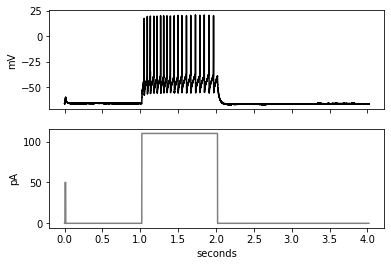

In [18]:
sweep_data = data_set.get_sweep(30)

i = sweep_data["stimulus"][0:sweep_data["index_range"][1]+1] # in A
v = sweep_data["response"][0:sweep_data["index_range"][1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t, i, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")


<br>**First question of this exercise:<br>Q1. What type of data is ```sweeps```? write some code that will give the answer in the cell below:**

In [9]:
import pandas as pd

That's a fine data type to use, but as we covered in the intro, the packages are what makes python powerful and a pandas DataFrame might be nice for searching for sweeps 

In [10]:
df_sweeps = pd.DataFrame(sweeps)

Welp, that didn't work.<br>
**Q2: why not? make the above cell work, without changing the code in the cell. add a cell above it, and then rerun the cell with ```df_sweeps = pd.DataFrame(sweeps)``` (or...if it did work...what had you done that made it work?)**

A nice feature of pandas DataFrames, like ```df_sweeps``` is being able to glimps at what's in them. we'll use ```.head()``` to show us just the first five entries in ```df_sweeps```, that way we can read all of the columns and get a flavor:

In [11]:
df_sweeps.head()

,bridge_balance_mohm,id,leak_pa,num_spikes,peak_deflection,post_noise_rms_mv,post_vm_mv,pre_noise_rms_mv,pre_vm_mv,slow_noise_rms_mv,...,stimulus_absolute_amplitude,stimulus_description,stimulus_duration,stimulus_interval,stimulus_name,stimulus_relative_amplitude,stimulus_start_time,stimulus_units,sweep_number,vm_delta_mv
0,0.000000,464306827,0.0,0.0,NaN,0.0,0.0,0.000000,0.000000,0.000000,...,10.000000,EXTPSMOKET141203[0],0.069995,0.05,Test,1.0,0.0300,Volts,0,0.0
1,0.000000,464306829,0.0,0.0,NaN,0.0,0.0,0.000000,0.000000,0.000000,...,10.000000,EXTPINBATH141203[0],0.069995,0.05,Test,1.0,0.0300,Volts,1,0.0
2,0.000000,464306863,0.0,0.0,NaN,0.0,0.0,0.000000,0.000000,0.000000,...,10.000000,EXTPCllATT141203[0],0.069995,0.05,Test,1.0,0.0300,Volts,2,0.0
3,0.000000,464306885,0.0,0.0,NaN,0.0,0.0,0.000000,0.000000,0.000000,...,10.000000,EXTPBREAKN141203[0],0.069995,0.05,Test,1.0,0.0300,Volts,3,0.0
4,16.178267,464306907,0.0,12.0,NaN,0.0,0.0,0.038605,-64.822418,0.155027,...,499.999986,C1RP25PR1S141203[0],19.997495,NaN,Ramp,1.0,1.0225,Amps,4,0.0


**Q3. How many sweeps, with any kind of current injection, were recorded done in this recording? write some code that will give the answer in the cell below:**
_note: there is not one way to do this; there are several. any is fine! 

What kind of stimuli were there in the sweeps? We find out from this DataFrame:

In [ ]:
df_sweeps.stimulus_name.unique()

Let's focus on one type of sweep, the "Long Square" that we plotted above. First, let's find all of the sweeps with a "Long Square" current injection. Because we have a pandas DataFrame, we can easily filter it for "Long Square"s:

In [ ]:
long_square_sweeps = df_sweeps[df_sweeps.stimulus_name == 'Long Square']
long_square_sweeps.head()

In [ ]:
print(long_square_sweeps.columns)

**Q4: How many different amplitudes of long sqaure pulse were applied? Make a variable called ```amplitudes``` that contains the absolute ampltiudes, and measure how may entries are in this variable.**

**Q5: How long (in duration) was each of these sweeps? make a variable called ```duration``` and assign it your answer (in seconds)** _hint: look at the other column names in ```grating_stimuli```_

Let's finish making our plot. We need to iterate over all of the presented sweeps. <br>
**Q6: What are all of the sweep numers for Long Squares?**

**Q7: for a sweep, use ```data_set.get_sweep(sweepnumber)``` to get the data. look in here to get the "stimulus" (in amps) and "response" (in V)**

**Q8: plot the response for each current stimulus. you are looking for something like the plot below, which we showed in the beginning**

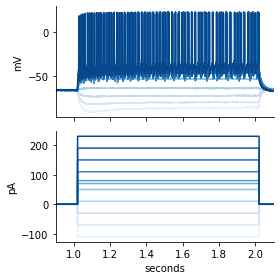